In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
#import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
#from textblob import TextBlob
#from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score



### Data Importing and Labeling

- In this step we clean the data and label the data as <br>
  > 0 for Negative <br>
  > 1 for Positive <br>
- Read the data and add new column for labels

In [2]:
#### import data #####
# label value = 1 for train positive  
train_pos = pd.read_csv('/Users/wuzijing/Desktop/aclImdb/train_pos.csv')
train_pos["sentiment"] = "1"
# label value = 0 for train negative
train_neg = pd.read_csv('/Users/wuzijing/Desktop/aclImdb/train_neg.csv')
train_neg["sentiment"] = "0"
# label value = 1 for test positive
test_pos = pd.read_csv('/Users/wuzijing/Desktop/aclImdb/test_pos.csv')
test_pos["sentiment"] = "1"
# label value = 0 for test negative
test_neg = pd.read_csv('/Users/wuzijing/Desktop/aclImdb/test_neg.csv')
test_neg["sentiment"] = "0"


In [3]:
# combine the train positive and train negative data 
train = [train_pos, train_neg]
train = pd.concat(train, ignore_index = True)

# combine the test positive and test negative data 
test = [test_pos, test_neg]
test = pd.concat(test, ignore_index = True)

In [4]:
#split the dataset  
#train dataset
#train_reviews=train.Review
train_sentiments=train.sentiment
#test dataset
#test_reviews=test.Review
test_sentiments=test.sentiment

#print(train_reviews.shape,train_sentiments.shape)
#print(test_reviews.shape,test_sentiments.shape)

### Data preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

- remove html tags using BeautifulSoup
- remove non-character such as digits and symbols
- convert to lower case
- remove stop words such as "the" and "and" if needed
- convert to root words by stemming if needed

In [5]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>


False

In [6]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [7]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
train['Review']=train['Review'].apply(denoise_text)
train['Review']=train['Review'].apply(remove_between_square_brackets)
train['Review']=train['Review'].apply(strip_html)
test['Review']=test['Review'].apply(denoise_text)
test['Review']=test['Review'].apply(remove_between_square_brackets)
test['Review']=test['Review'].apply(strip_html)

In [8]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
train['Review']=train['Review'].apply(remove_special_characters)

In [9]:
test['Review']=test['Review'].apply(remove_special_characters)

In [10]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
train['Review']=train['Review'].apply(simple_stemmer)

In [11]:
test['Review']=test['Review'].apply(simple_stemmer)

In [12]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
train['Review']=train['Review'].apply(remove_stopwords)

{'to', 'been', 'can', 'how', 'was', 'y', 'each', 'will', 'out', 'only', 'ma', 'between', "don't", 'with', 'theirs', 'their', 'the', 'be', 'you', 'once', 'very', 'himself', 'having', 'into', 'by', 'hadn', 'again', 'until', 'a', "won't", 'against', 'mustn', 'through', 'd', 'couldn', "haven't", 'same', 'wasn', 'haven', "isn't", 'did', 'not', 'off', 'below', 'our', 'o', 'mightn', "weren't", 'my', 'so', "you'll", "didn't", 'its', 's', "it's", 'he', "hadn't", 'doesn', 'this', 'it', 'because', 'his', 'me', 'in', 'and', "mustn't", "shouldn't", 'don', 'them', 'yours', 'these', 'being', 'yourself', 'shouldn', 'should', 'few', 're', 'most', 'that', 'other', 'as', "aren't", "wasn't", 'myself', 'she', 'what', 'doing', 'those', 'do', 'wouldn', 'aren', 'before', 'more', 'are', 'up', 've', 'ourselves', 'm', 'which', 'they', 'about', 'on', 'i', 'll', 'ours', 'own', 'now', 'too', "shan't", 'over', 'had', 'shan', "needn't", 'whom', 'just', 'no', 'needn', 'both', "couldn't", 'if', 'does', 'were', 'her', '

In [13]:
test['Review']=test['Review'].apply(remove_stopwords)

In [14]:
#normalized train reviews
norm_train_reviews=train['Review']
norm_train_reviews[0]

'bromwel high cartoon comedi ran time program school life teacher 35 year teach profess lead believ bromwel high satir much closer realiti teacher scrambl surviv financi insight student see right pathet teacher pomp petti whole situat remind school knew student saw episod student repeatedli tri burn school immedi recal high classic line inspector Im sack one teacher student welcom bromwel high expect mani adult age think bromwel high far fetch piti isnt'

In [15]:
#Normalized test reviews
norm_test_reviews=test['Review']
norm_test_reviews[4]

'bill paxton ha taken true stori 1913 US golf open made film much extraordinari game golf film also deal directli class tension earli twentieth centuri touch upon profound anticathol prejudic british american establish heart film perenni favourit triumph oddsth act exemplari throughout stephen dillan excel usual revel movi shia laboeuf deliv disciplin dignifi highli sympathet perform work class francoirish kid fight hi way prejudic new england wasp establish onli familiar hi slapstick perform even steven thi demonstr hi matur delight surpris josh flitter ten year old caddi threaten steal everi scene appearsa old fashion movi best sens word fine act clear direct great stori grip end final scene affection nod casablanca one mani pleasur fill great movi'

## Bags of words model

- It is used to convert text documents to numerical vectors or bag of words.
- It is a simplifying representation used in natural language processing and information retrieval. 
- In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. 

In [16]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (25000, 4145255)
BOW_cv_test: (25000, 4145255)


## Term Frequency-Inverse Document Frequency model (TFIDF)
- It is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.
- It is done by 
  > how many times a word appears in a document <br>
  > the inverse document frequency of the word across a set of documents <br>

In [17]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (25000, 4145255)
Tfidf_test: (25000, 4145255)


## Modelling the dataset - logistic regression
- build logistic regression for both bags of word and TFIDF 

In [18]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train['sentiment'])
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train['sentiment'])
print(lr_tfidf)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [19]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

['1' '1' '1' ... '0' '0' '1']
['1' '1' '1' ... '0' '0' '1']


In [20]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.68784
lr_tfidf_score : 0.68728


## Classification report-logistic regression 
- The F1 score is a weighted harmonic mean of precision and recall, which is used to compare classifier models.
- In this case, the accuracy F1 score for bag of words is 0.69,which is the same as TFIDF.

In [21]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.68      0.72      0.70     12500
    Negative       0.70      0.66      0.68     12500

    accuracy                           0.69     25000
   macro avg       0.69      0.69      0.69     25000
weighted avg       0.69      0.69      0.69     25000

              precision    recall  f1-score   support

    Positive       0.67      0.73      0.70     12500
    Negative       0.70      0.65      0.67     12500

    accuracy                           0.69     25000
   macro avg       0.69      0.69      0.69     25000
weighted avg       0.69      0.69      0.69     25000



## Modelling the dataset - Multinomial Naive Bayes 
- Multinomial Naive Bayes for bag of words and tfidf 
- It is based on the Bayes Rule which describes the probability of an event

In [25]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [26]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

['1' '1' '1' ... '0' '0' '1']
['1' '1' '1' ... '0' '0' '1']


In [27]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.68728
mnb_tfidf_score : 0.68728


## Classification report - Multinomial Naive Bayes
- In this case, the accuracy F1 score for bag of words is 0.69,which is the same as TFIDF.

In [28]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.67      0.73      0.70     12500
    Negative       0.70      0.65      0.67     12500

    accuracy                           0.69     25000
   macro avg       0.69      0.69      0.69     25000
weighted avg       0.69      0.69      0.69     25000

              precision    recall  f1-score   support

    Positive       0.67      0.73      0.70     12500
    Negative       0.70      0.65      0.67     12500

    accuracy                           0.69     25000
   macro avg       0.69      0.69      0.69     25000
weighted avg       0.69      0.69      0.69     25000



## Positive and negative words by using WordCloud

<function matplotlib.pyplot.show(*args, **kw)>

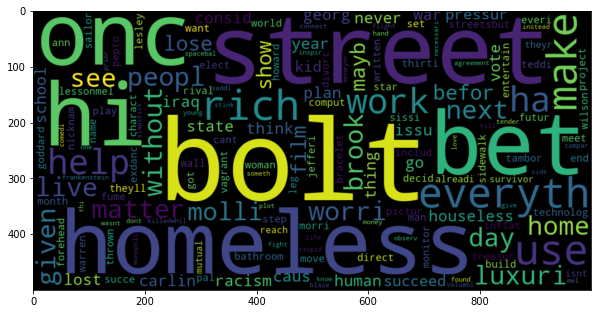

In [23]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

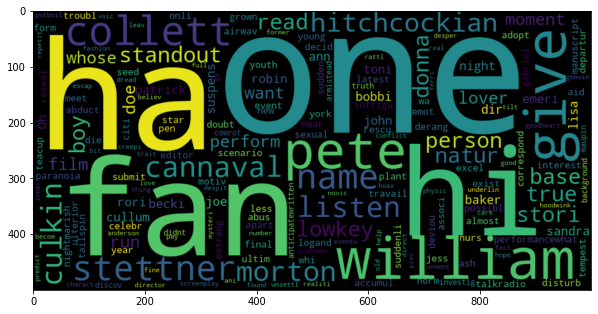

In [24]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

## Conclusion
- It shows that both logistic regression and multinomial naive bayes model using bags of model and TFIDF performing well and reached 0.69 accuracy scores.
- Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.